[[0.35 0.23 1.93]]


/home/shisei/work/lstm/ThermoDetection/Scene.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot.plot(*camera_position[:2], 'ro', color=camera.color)


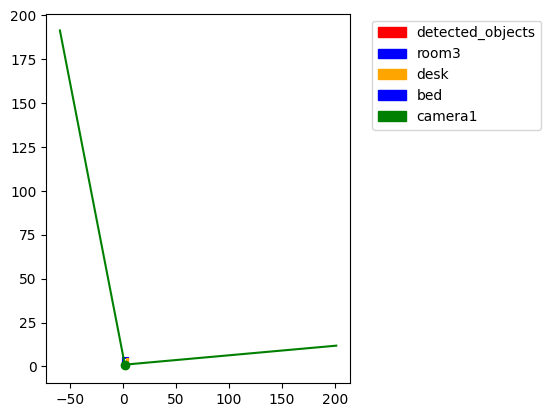

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision.models as models
from setting import *
import cv2
import numpy as np
from tqdm.notebook import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from utils import *
from Dataset import *
import argparse
import logging
# ログレベルの設定
logging.getLogger("ultralytics").setLevel(logging.ERROR)
def fix_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
fix_seeds()
device = "cuda" if torch.cuda.is_available() else "cpu"
classes = {0:"usual", 1:"slipped", 2:"fell", 3:"falling"}
# Model, loss function, and optimizer
from eval_fall_slip import fall_slip_matrix, fall_slip_matrix2, eval_HMM
import mlflow
from train import train_model
from models.ConvLSTM import ConvLSTM
from dataaugmentation import VideoDataAugmentation

In [ ]:
cfg = get_cnf("base.yaml")
basic_info = cfg["base"] 
train_set = cfg["train_set"]
params = cfg["parameters"]
features_col = cfg["features"]
epochs = params["epochs"]
transform = VideoDataAugmentation() if params["transform"] else None
train_video_dir = glob(train_set["train_video_dir"])
val_video_dir = glob(train_set["val_video_dir"])
from Dataset import ThermalFallDataset
train_dataset = ThermalFallDataset(train_video_dir, annotaiton_csv_path=train_set["annotaiton_csv_path"], window_size=params["window_size"], cache_file='./thermal_train_fall_cache.npz', transform=transform, image_f=params["image_f"], col=features_col, preprocess_f=params["preprocess_f"], jpg=True)
val_dataset = ThermalFallDataset(val_video_dir, annotaiton_csv_path=train_set["annotaiton_csv_path"], window_size=params["window_size"], cache_file='./thermal_train_fall_cache.npz', transform=transform, image_f=params["image_f"], col=features_col, preprocess_f=params["preprocess_f"], jpg=True)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=0) # , pin_memory=True
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=0) # , pin_memory=True
eventdata = EventFallDataset(cfg, video_dirs=cfg["train_set"]["event_video_dir"], anno_csv=cfg["train_set"]["event_annotation_csv_path"])

# train_val_process function


In [7]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [ ]:
train_label_counts = [797,1195,2679]
class_weights = torch.tensor([1/train_label_counts[i]*1000 if train_label_counts[i] != 0 else 0 for i in range(params["class_num"])], device=device)
criterion = FocalLoss(weight=class_weights)


In [ ]:
def train_val_process(config_path,DEBUG=False, run_id=None):
    global train_dataset, val_dataset, train_loader, val_loader, eventdata, criterion
    fix_seeds()
    cfg = get_cnf(config_path)
    print(cfg)
    basic_info = cfg["base"] 
    train_set = cfg["train_set"]
    params = cfg["parameters"]
    features_col = cfg["features"]
    epochs = params["epochs"]
    train_dataset.set_features_to_use(features_col, params["preprocess_f"])
    val_dataset.set_features_to_use(features_col, params["preprocess_f"])
    eventdata.set_features_to_use(features_col, params["preprocess_f"])


    save_dir = os.path.join(WORKDIR, "RESULT", cfg["base"]["experiment_name"], cfg["base"]["run_name"])    
    with mlflow.start_run(run_name=basic_info["run_name"], run_id=run_id) as run:
        mlflow.set_experiment(basic_info["experiment_name"])
        
        DEBUG = False
        from train import train_model, Eval
        from models.ConvLSTM import ConvLSTM
        save_dir = os.path.join(WORKDIR, "RESULT", cfg["base"]["experiment_name"], cfg["base"]["run_name"])
        os.makedirs(save_dir, exist_ok=True)
        model = ConvLSTM(num_classes=params["class_num"], feature_col=len(cfg["features"]), num_layers=params["num_layers"], motion_f=params["motion_f"],
                         hidden_dim=params["hidden_dim"], resnet_output_dim=params["resnet_output_dim"], image_f=params["image_f"])
        best_val_loss = float('inf')
        model = model.to(device)
        mlflow.log_params(params)
        mlflow.log_artifact(cfg["base"]["filename"], "config")
        
        optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=0.0001)
        
        train_eval = Eval(cfg, len(train_loader), eval_type="train", classes=train_set["classes"])
        val_eval = Eval(cfg, len(val_loader), eval_type="val", classes=train_set["classes"])
        for epoch in tqdm(range(epochs), desc="Epoch"):
            # トレーニングループ
            model.train()
            train_loss = 0
            iter = 0
            for inputs, labels, features in tqdm(train_loader, desc="Iteration", leave=False):
                inputs, labels, features = inputs.to(device), labels.to(device), features.to(device)
                # inputs = inputs.float()  # floatにキャスト
                optimizer.zero_grad()
                outputs = model(inputs, features)
                loss = criterion(outputs, labels)
                train_eval.calculate_metrics(outputs, labels, loss)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                if DEBUG and iter > 10:
                    break
                else:
                    iter += 1

            train_loss /= len(train_loader)
            mlflow.log_metric('train_loss', train_loss, step=epoch)
            for idx, name in train_set["classes"].items():
                mlflow.log_metric(f'train_{name}_precision',np.mean(train_eval.class_precision[idx]), step=epoch)
                mlflow.log_metric(f'train_{name}_recall',np.mean(train_eval.class_recall[idx]), step=epoch)
                mlflow.log_metric(f'train_{name}_f1',np.mean(train_eval.class_f1[idx]), step=epoch)
            
            train_eval.print_eval()
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}')
        
            # 検証ループ
            model.eval()
            val_loss = 0
            iter = 0
            with torch.no_grad():
                for inputs, labels, features in val_loader:
                    inputs, labels, features = inputs.to(device), labels.to(device), features.to(device)
                    # inputs = inputs.float()  # floatにキャスト
                    outputs = model(inputs, features)
                    loss = criterion(outputs, labels)
                    val_eval.calculate_metrics(outputs, labels, loss)
                    val_loss += loss.item()
                    if DEBUG and iter > 10:
                        break
                    else:
                        iter += 1
        
            val_loss /= len(val_loader)
            mlflow.log_metric('val_loss', val_loss, step=epoch)
            for idx, name in train_set["classes"].items():
                mlflow.log_metric(f'val_{name}_precision',np.mean(val_eval.class_precision[idx]), step=epoch)
                mlflow.log_metric(f'val_{name}_recall',np.mean(val_eval.class_recall[idx]), step=epoch)
                mlflow.log_metric(f'val_{name}_f1',np.mean(val_eval.class_f1[idx]), step=epoch)
            val_eval.print_eval()
            print(f'Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss:.4f}')
        
        
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                print("updata best ckpt")
                save_model_path = f'{save_dir}/best_ckpt.pth'
                torch.save(model.state_dict(), save_model_path)
                mlflow.log_artifact(save_model_path, "best_model")
        
        print("####################### Training completed.")

        
        print("####################### Val Event")
        eventdata = EventFallDataset(cfg, video_dirs=cfg["train_set"]["event_video_dir"], anno_csv=cfg["train_set"]["event_annotation_csv_path"])
        event_val = os.path.basename(os.path.dirname(train_set["event_video_dir"]))
        model_outputs, labels = eventdata.inference(model)
        event_fall_csv_path = f"{save_dir}/lstm_prob_{event_val}.csv"
        tmp_df = pd.DataFrame(np.concatenate([np.concatenate([[np.zeros(3) for _ in range(params["window_size"])], [o for o in model_outputs]]),
                                     np.expand_dims(labels, axis=
                                                    1)], 1), columns=["usual", "falling", "fall", "label"])
        tmp_df.to_csv(event_fall_csv_path)
        mlflow.log_artifact(event_fall_csv_path, "event_eval_csv")
        data = pd.read_csv(event_fall_csv_path, index_col=0)
        from eval_fall_slip import plot_pr
        TP_event = plot_pr(data,save_dir)
        
        mlflow.log_artifact(f"{save_dir}/recall_precision.png", "event_eval_result")
        mlflow.log_artifact(f"{save_dir}/recall_precision.csv", "event_eval_result")
        fall_slip_matrix(data, TP_event, save_dir)
        mlflow.log_artifact(f"{save_dir}/confusion_matrices.png", "event_eval_result")

        print("####################### Eval Event completed")

# 個別の実験

{'hydra': {'run': {'dir': 'outputs/${now:%Y-%m-%d}/${now:%H-%M-%S}'}, 'sweep': {'dir': 'multirun/${now:%Y-%m-%d}/${now:%H-%M-%S}', 'subdir': '${hydra.job.num}'}, 'launcher': {'_target_': 'hydra._internal.core_plugins.basic_launcher.BasicLauncher'}, 'sweeper': {'_target_': 'hydra._internal.core_plugins.basic_sweeper.BasicSweeper', 'max_batch_size': None, 'params': None}, 'help': {'app_name': '${hydra.job.name}', 'header': '${hydra.help.app_name} is powered by Hydra.\n', 'footer': 'Powered by Hydra (https://hydra.cc)\nUse --hydra-help to view Hydra specific help\n', 'template': '${hydra.help.header}\n== Configuration groups ==\nCompose your configuration from those groups (group=option)\n\n$APP_CONFIG_GROUPS\n\n== Config ==\nOverride anything in the config (foo.bar=value)\n\n$CONFIG\n\n${hydra.help.footer}\n'}, 'hydra_help': {'template': "Hydra (${hydra.runtime.version})\nSee https://hydra.cc for more info.\n\n== Flags ==\n$FLAGS_HELP\n\n== Configuration groups ==\nCompose your configura

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/292 [00:00<?, ?it/s]


        Accuracy: 0.2715
        Precision: 0.7577
        Recall: 0.7679
        F1_score: 0.7602
        Sensitivity: 0.7679
        Specificity: 0.9098
        mAP: 0.7012
        
Class usual - Precision: 0.7325, Recall: 0.9061, F1_score: 0.7811
Class falling - Precision: 0.5985, Recall: 0.5436, F1_score: 0.5281
Class fall - Precision: 0.9421, Recall: 0.8540, F1_score: 0.8789
Epoch [1/5], Train Loss: 0.1489

        Accuracy: 0.2436
        Precision: 0.6475
        Recall: 0.6566
        F1_score: 0.6468
        Sensitivity: 0.6566
        Specificity: 0.8661
        mAP: 0.5875
        
Class usual - Precision: 0.5380, Recall: 0.9624, F1_score: 0.6726
Class falling - Precision: 0.4820, Recall: 0.2473, F1_score: 0.3046
Class fall - Precision: 0.9225, Recall: 0.7602, F1_score: 0.8245
Epoch [1/5], Val Loss: 0.1895
updata best ckpt


Iteration:   0%|          | 0/292 [00:00<?, ?it/s]


        Accuracy: 0.3081
        Precision: 0.8756
        Recall: 0.8855
        F1_score: 0.8794
        Sensitivity: 0.8855
        Specificity: 0.9645
        mAP: 0.6467
        
Class usual - Precision: 0.8877, Recall: 0.9581, F1_score: 0.9095
Class falling - Precision: 0.7626, Recall: 0.7468, F1_score: 0.7326
Class fall - Precision: 0.9765, Recall: 0.9515, F1_score: 0.9613
Epoch [2/5], Train Loss: 0.0555

        Accuracy: 0.2467
        Precision: 0.6682
        Recall: 0.6878
        F1_score: 0.6755
        Sensitivity: 0.6878
        Specificity: 0.8643
        mAP: 0.5403
        
Class usual - Precision: 0.6668, Recall: 0.7375, F1_score: 0.6692
Class falling - Precision: 0.4695, Recall: 0.5298, F1_score: 0.4589
Class fall - Precision: 0.8683, Recall: 0.7959, F1_score: 0.8229
Epoch [2/5], Val Loss: 0.2335


Iteration:   0%|          | 0/292 [00:00<?, ?it/s]


        Accuracy: 0.3114
        Precision: 0.8847
        Recall: 0.9007
        F1_score: 0.8915
        Sensitivity: 0.9007
        Specificity: 0.9694
        mAP: 0.6407
        
Class usual - Precision: 0.8909, Recall: 0.9373, F1_score: 0.9027
Class falling - Precision: 0.7833, Recall: 0.8057, F1_score: 0.7709
Class fall - Precision: 0.9799, Recall: 0.9593, F1_score: 0.9676
Epoch [3/5], Train Loss: 0.0476

        Accuracy: 0.2786
        Precision: 0.7818
        Recall: 0.7778
        F1_score: 0.7781
        Sensitivity: 0.7778
        Specificity: 0.9025
        mAP: 0.6269
        
Class usual - Precision: 0.9250, Recall: 0.8682, F1_score: 0.8797
Class falling - Precision: 0.5601, Recall: 0.5673, F1_score: 0.5344
Class fall - Precision: 0.8602, Recall: 0.8979, F1_score: 0.8724
Epoch [3/5], Val Loss: 0.1557
updata best ckpt


Iteration:   0%|          | 0/292 [00:00<?, ?it/s]


        Accuracy: 0.3165
        Precision: 0.9133
        Recall: 0.9205
        F1_score: 0.9160
        Sensitivity: 0.9205
        Specificity: 0.9770
        mAP: 0.6320
        
Class usual - Precision: 0.9226, Recall: 0.9656, F1_score: 0.9365
Class falling - Precision: 0.8332, Recall: 0.8277, F1_score: 0.8098
Class fall - Precision: 0.9841, Recall: 0.9683, F1_score: 0.9743
Epoch [4/5], Train Loss: 0.0321

        Accuracy: 0.2804
        Precision: 0.8001
        Recall: 0.8070
        F1_score: 0.8014
        Sensitivity: 0.8070
        Specificity: 0.9090
        mAP: 0.6472
        
Class usual - Precision: 0.8797, Recall: 0.7928, F1_score: 0.8177
Class falling - Precision: 0.6394, Recall: 0.7414, F1_score: 0.6582
Class fall - Precision: 0.8812, Recall: 0.8868, F1_score: 0.8763
Epoch [4/5], Val Loss: 0.1337
updata best ckpt


Iteration:   0%|          | 0/292 [00:00<?, ?it/s]


        Accuracy: 0.3173
        Precision: 0.9168
        Recall: 0.9274
        F1_score: 0.9213
        Sensitivity: 0.9274
        Specificity: 0.9780
        mAP: 0.6435
        
Class usual - Precision: 0.9323, Recall: 0.9693, F1_score: 0.9433
Class falling - Precision: 0.8326, Recall: 0.8438, F1_score: 0.8162
Class fall - Precision: 0.9856, Recall: 0.9692, F1_score: 0.9757
Epoch [5/5], Train Loss: 0.0298

        Accuracy: 0.2628
        Precision: 0.7396
        Recall: 0.7689
        F1_score: 0.7518
        Sensitivity: 0.7689
        Specificity: 0.8976
        mAP: 0.6386
        
Class usual - Precision: 0.8089, Recall: 0.8551, F1_score: 0.8099
Class falling - Precision: 0.4895, Recall: 0.6670, F1_score: 0.5280
Class fall - Precision: 0.9206, Recall: 0.7847, F1_score: 0.8379
Epoch [5/5], Val Loss: 0.1817
####################### Training completed.
####################### Val Event
Threshold argmax
D max 8
TP: 5, FP: 7, TN: 0, FN: 6
recall: 0.455
precision: 0.417
f1: 0.435

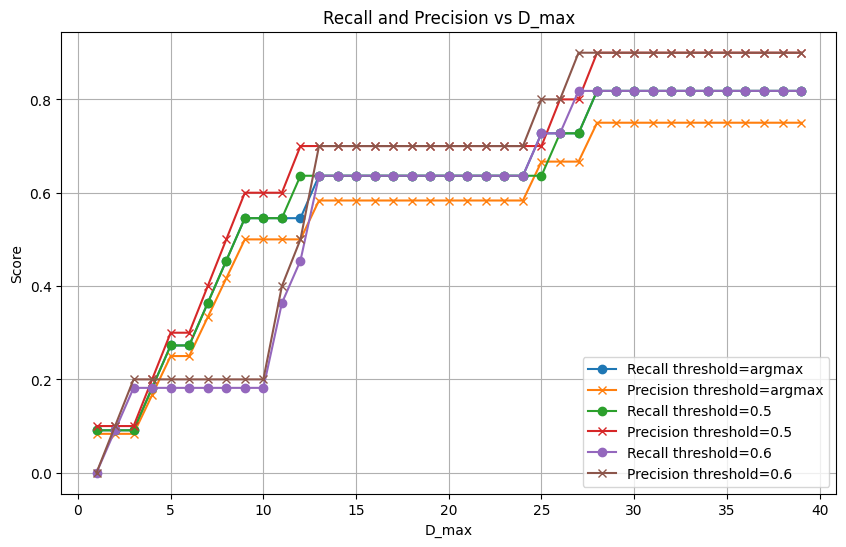

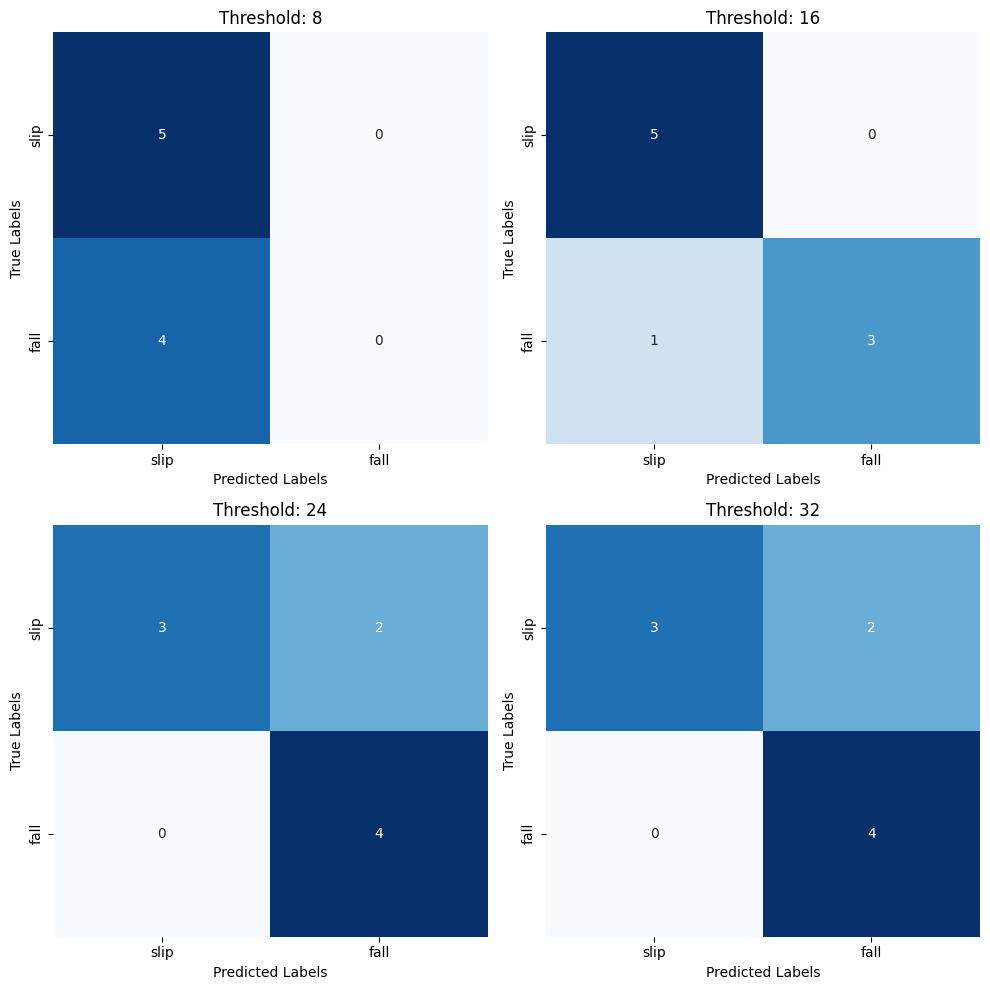

Threshold: 8
  Slip Accuracy: 1.00
  Fall Accuracy: 0.00
Threshold: 16
  Slip Accuracy: 1.00
  Fall Accuracy: 0.75
Threshold: 24
  Slip Accuracy: 0.60
  Fall Accuracy: 1.00
Threshold: 32
  Slip Accuracy: 0.60
  Fall Accuracy: 1.00
####################### Eval Event completed


In [14]:
train_val_process("config16-6.yaml")